In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"

import mitsuba as mi
import drjit as dr
from matplotlib import pyplot as plt
import numpy as np
import cv2

print(mi.variants())
mi.set_variant("cuda_ad_spectral_polarized")

['scalar_rgb', 'scalar_spectral', 'scalar_spectral_polarized', 'llvm_ad_rgb', 'llvm_ad_mono', 'llvm_ad_mono_polarized', 'llvm_ad_spectral', 'llvm_ad_spectral_polarized', 'cuda_ad_rgb', 'cuda_ad_mono', 'cuda_ad_mono_polarized', 'cuda_ad_spectral', 'cuda_ad_spectral_polarized']


In [2]:
def render(scene, polarization_angle=0, spp=512):
	# Adjust angle of polarizer
	params = mi.traverse(scene)
	params["polarizer_cam.bsdf.theta.value"] = polarization_angle
	params.update()

	image = np.array(mi.render(scene, spp=spp))

	# Clip image to be >= 0
	image[image < 0] = 0

	return image

In [3]:
def separate_lighting(img_0, img_90):
	indirect = 2 * np.fmin(img_0, img_90)
	direct = img_0 - indirect / 2

	return indirect, direct

In [4]:
# images: (H, W, n)
# angles: (n)
def fit_polarization_params(images, angles):
	angles_rad = np.deg2rad(angles)

	cos2theta = np.cos(2 * angles_rad)
	sin2theta = np.sin(2 * angles_rad)

	A = np.stack([np.ones_like(angles_rad), cos2theta, sin2theta], axis=1)
	A_pinv = np.linalg.pinv(A)

	fit_params = np.tensordot(images, A_pinv.T, axes=([2], [0]))
	a, b, c = fit_params[..., 0], fit_params[..., 1], fit_params[..., 2]

	unpolarized = a
	polarized = np.sqrt(b ** 2 + c ** 2)
	DoLP = polarized / (unpolarized + 1e-8) # Degree of Linear Polarization
	AoLP = 0.5 * np.arctan2(c, b) # Angle of Linear Polarization

	return unpolarized, polarized, DoLP, AoLP

In [11]:
def separate_lighting_advanced(scene, angles):
	images = np.stack([render(scene, polarization_angle=angle, spp=512) for angle in angles], axis=-1)

	indirect_list = []
	direct_list = []
	DoLP_list = []
	AoLP_list = []

	for channel in range(3):
		indirect, direct, DoLP, AoLP = fit_polarization_params(images[:, :, channel, :], angles)

		indirect_list.append(indirect)
		direct_list.append(direct)
		DoLP_list.append(DoLP)
		AoLP_list.append(AoLP)

	DoLP = np.stack(DoLP_list, axis=-1)
	AoLP = np.stack(AoLP_list, axis=-1)

	DoLP_mean = np.mean(DoLP, axis=-1)

	cos2phi = np.sum(np.cos(2 * AoLP), axis=-1)
	sin2phi = np.sum(np.sin(2 * AoLP), axis=-1)
	AoLP_avg = 0.5 * np.arctan2(sin2phi, cos2phi)

	return np.stack(indirect_list, axis=-1), np.stack(direct_list, axis=-1), DoLP_mean, AoLP_avg

In [15]:
scene = mi.load_file("marcus_light_sphere.xml")

In [20]:
angles = np.array([0, 30, 60, 90, 120, 150])

indirect, direct, DoLP, AoLP = separate_lighting_advanced(scene, angles)

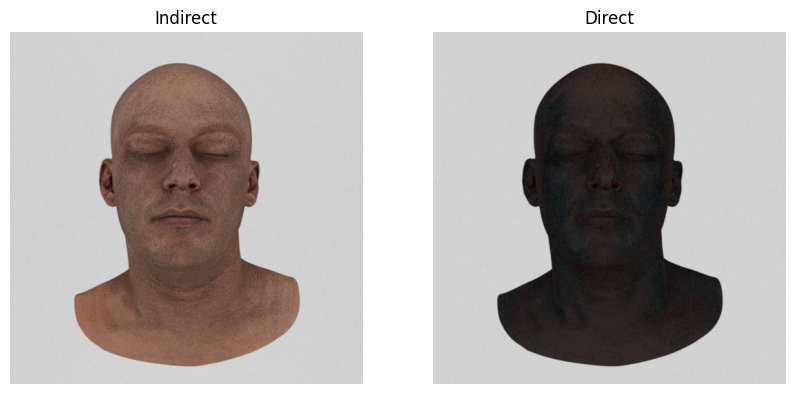

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].axis("off")
ax[0].imshow(indirect ** (1.0 / 2.2))
ax[0].set_title("Indirect")

ax[1].axis("off")
ax[1].imshow(direct ** (1.0 / 2.2))
ax[1].set_title("Direct")

plt.show()

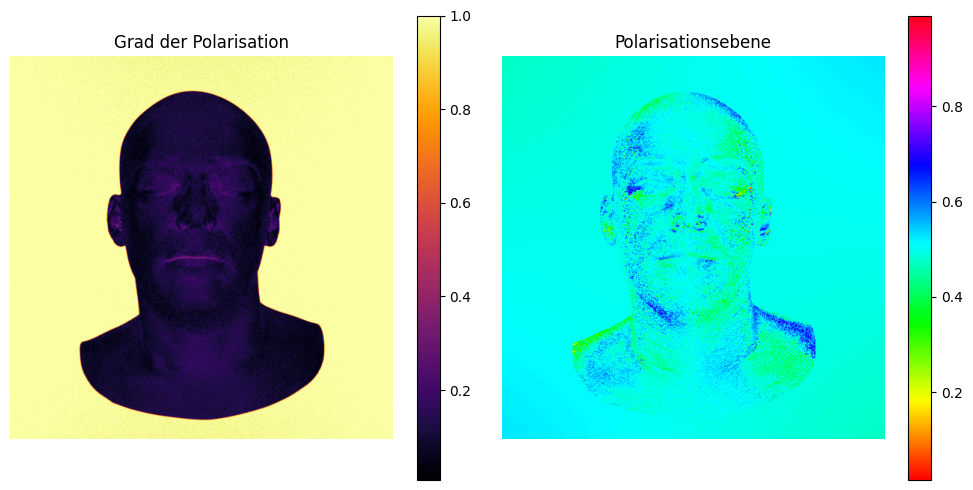

In [22]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(np.clip(DoLP, 0, 1), cmap="inferno")
plt.title("Grad der Polarisation")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow((AoLP + np.pi/2) / np.pi, cmap="hsv")
plt.title("Polarisationsebene")
plt.colorbar()

plt.tight_layout()
plt.show()